In [567]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from skimage import transform

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

def generate_random_rgb():
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

random.seed(3)
rgb_dict_with_function = {i: generate_random_rgb() for i in range(10)}

In [790]:
def find_bbox(object, 
              topleft_bottomright_coordinates=True):
    # Find the non-zero pixels
    coords = np.column_stack(np.where(object > 0)).astype(float)
    coords[:, 0] = coords[:, 0] / object.shape[0]
    coords[:, 1] = coords[:, 1] / object.shape[1]
    # Find the top_left bottom_right bounding box coordinates
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)

    # return specified label-type (top-left, bottom-right coordinates) 
    if topleft_bottomright_coordinates:
        return np.array([x_min,
                         y_min,
                         x_max,
                         y_max])
    # (center-coordinate, width, height)
    else:
        # Find center, width, and height bounding box coordinates
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min
        return np.array([x_center,
                         y_center,
                         width,
                         height])


def add_bbox_to_object(object, 
                       label, 
                       label_color_map, 
                       topleft_bottomright_coordinates=True):
    # retrieve rectangle coordinates
    if topleft_bottomright_coordinates:
        x_min, y_min, x_max, y_max = label[1:]
    else:
        x_center, y_center, width, height = label[1:]
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2
    # Upscale from normalized coordinates
    x_min = int(np.floor(x_min * object.shape[0]))
    y_min = int(np.floor(y_min * object.shape[1]))
    x_max = int(np.ceil(x_max * object.shape[0]))
    y_max = int(np.ceil(y_max * object.shape[1]))

    object = np.stack([object, object, object], axis=-1)  # Convert to RGB
    object_with_bbox = cv2.rectangle(object, 
                                     (y_min, x_min), 
                                     (y_max, x_max),
                                     color=label_color_map[label[0]], 
                                     thickness=1)
    # Calculate normalized coordinates
    return object_with_bbox


def plot_mnist_objects_with_bbox(objects, 
                                 labels, 
                                 label_color_map,
                                 classes = 10,
                                 repeats = 5,
                                 topleft_bottomright_coordinates=True):
    

    plt.figure(figsize=(2 * classes, 2 * repeats))
    for i in range(repeats):
        for j in range(classes):
            plt.subplot(repeats, classes, i * classes + j + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            # find the index of the first example of current i in data 
            index = np.where(labels[:, 0] == j)[0][i]

            object_with_bbox = add_bbox_to_object(objects[index],
                                                  labels[index],
                                                  label_color_map,
                                                  topleft_bottomright_coordinates=topleft_bottomright_coordinates)
            plt.imshow(object_with_bbox)
            plt.xlabel(j)
    plt.show()


def plot_image_from_grayscale(object):
    object = np.stack([object, object, object], axis=-1)
    plt.figure(figsize=(6, 6))
    plt.imshow(object, vmin=0, vmax=255)
    plt.axis('off')
    plt.show()


def draw_grid_on_image(image, grid_height, grid_width):
    # Get the shape of the image
    height, width = image.shape
    
    # Calculate the step size for rows and columns
    row_step = height // grid_height
    col_step = width // grid_width

    # Set grid lines to zero (black)
    for i in range(1, grid_height):
        image[i * row_step, :] = 0  # Horizontal lines
    for j in range(1, grid_width):
        image[:, j * col_step] = 0  # Vertical lines

    return image


In [569]:
x_train_bboxes = []
for object in x_train:
    x_train_bboxes.append(find_bbox(object))
x_train_bboxes = np.array(x_train_bboxes)

y_train_bboxes = np.hstack([y_train, x_train_bboxes])

x_test_bboxes = []
for object in x_test:
    x_test_bboxes.append(find_bbox(object))
x_test_bboxes = np.array(x_test_bboxes)

y_test_bboxes = np.hstack([y_test, x_test_bboxes])

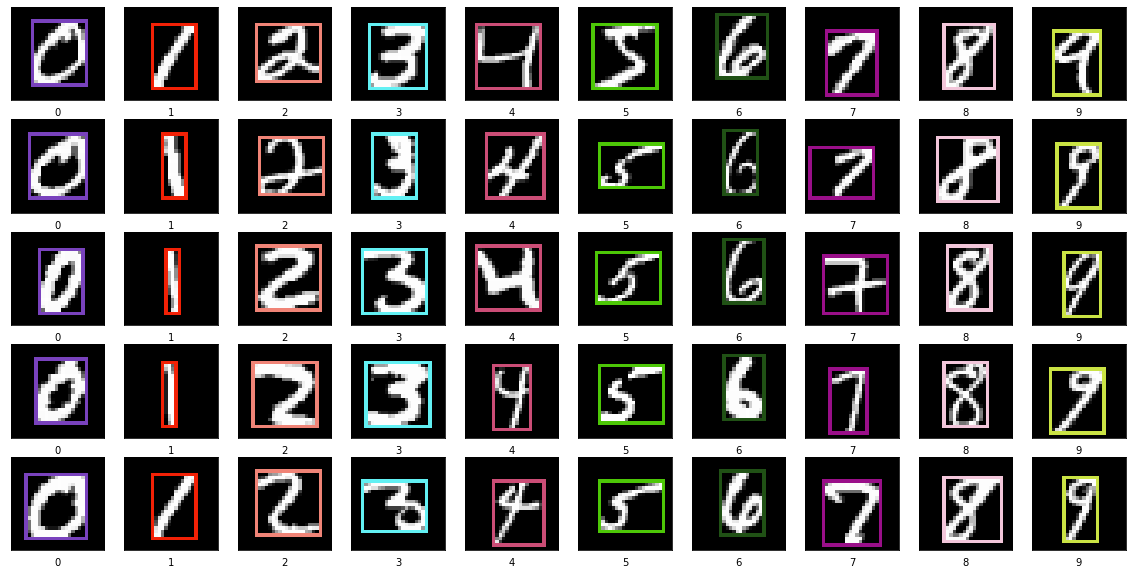

In [593]:
plot_mnist_objects_with_bbox(x_train,
                            y_train_bboxes,
                            label_color_map=rgb_dict_with_function)

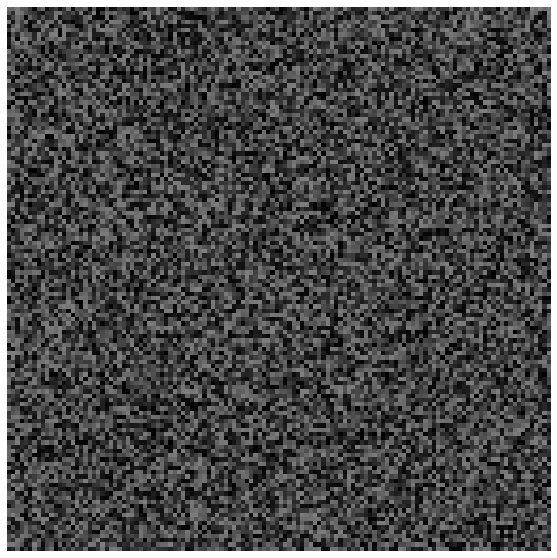

In [726]:
def generate_noisy_image(size=(128, 128),
                         intensity = 128):
    # Generate a random array of shape size with values between 0 and 255
    random_image = np.random.randint(0, intensity, size, dtype=np.uint8)
    return random_image

# Generate a random 64x64 grayscale object
image = generate_noisy_image()

# Display the object
plot_image_from_grayscale(image)

In [573]:
def choose_regions_to_populate(max_objects = 8,
                               grid_height = 4,
                               grid_width = 4):
    
    num_objects = np.random.choice(range(max_objects), 1)
    regions = np.random.choice(range(1, grid_width * grid_height + 1), 
                               num_objects, 
                               replace=False)
    return regions

In [574]:
def grab_x_bbox_region(object, 
                       label,
                       topleft_bottomright_coordinates=True):
    if topleft_bottomright_coordinates:
        x_min, y_min, x_max, y_max = label[1:]
    else:
        x_center, y_center, width, height = label[1:]
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2
    # Upscale from normalized coordinates
    x_min = int(np.floor(x_min * object.shape[0]))
    y_min = int(np.floor(y_min * object.shape[1]))
    x_max = int(np.ceil(x_max * object.shape[0]))
    y_max = int(np.ceil(y_max * object.shape[1]))

    return object[x_min:x_max, y_min:y_max]

In [760]:
def add_object_to_image(image,
                        region_of_interest,
                        object,
                        label,
                        grid_height = 4,
                        grid_width = 4,
                        scale_value = 1,
                        topleft_bottomright_coordinates=True):

    # Determine the size of a region based on chosen image grid
    region_y = int(image.shape[0] / grid_height)
    region_x = int(image.shape[1] / grid_width)
    # Randomly choose a center point within the size of one grid region
    x_center = np.random.randint(0, region_x + 1, 1)
    y_center = np.random.randint(0, region_y + 1, 1)
    # Offset center to the chosen region of interest 

    x_center += ((region_of_interest - 1)// grid_width) * region_x
    y_center += ((region_of_interest - 1) % grid_width) * region_y
    
    # Grab the bbox area of the input object for overlaying onto the image
    bbox_object = grab_x_bbox_region(object,
                                     label,
                                     topleft_bottomright_coordinates=topleft_bottomright_coordinates)
   
    # Find all edge regions on graph such that no scaling will happen in these regions due to potential to be placed outside image
    edge_regions = list(range(1, grid_width + 1))
    edge_regions += list(range(grid_width + 1, (grid_height - 1) * grid_width , grid_width))
    edge_regions += list(range(grid_width * 2, ((grid_height - 1) * grid_width  + 1), grid_width))
    edge_regions += list(range((grid_height - 1) * grid_width + 1, grid_height * grid_width + 1))
    
    if scale_value != 1 and region_of_interest not in edge_regions:
        bbox_object = transform.rescale(bbox_object, 
                                        scale_value,
                                        mode = 'constant',
                                        cval = 0,
                                        anti_aliasing=False,
                                        preserve_range=True)
    # Find new size of bbox object
    m, n = bbox_object.shape
    
    # Calculate image location for bbox object
    top = int((y_center - n // 2))
    left = int((x_center - m // 2))
    bot = int(top + n)
    right = int(left + m)

    #print("region: {}, ({},{}) , ({},{})".format(region_of_interest, left, top, right, bot))

    if top < 0:
        up_shift = 0 - top
        top, bot = top + up_shift, bot + up_shift
    elif bot >= image.shape[1]:
        down_shift = (bot - image.shape[1]) + 1
        top, bot = top - down_shift, bot - down_shift  

    if left < 0:
        r_shift = 0 - left
        left, right = left + r_shift, right + r_shift
    elif right >= image.shape[0]:
        l_shift = (right - image.shape[0]) + 1
        left, right = left - l_shift, right - l_shift

    #print("region: {}, ({},{}) , ({},{})".format(region_of_interest, left, top, right, bot))

    image[left:right, top:bot] = np.maximum(image[left:right, top:bot], bbox_object)

    return image


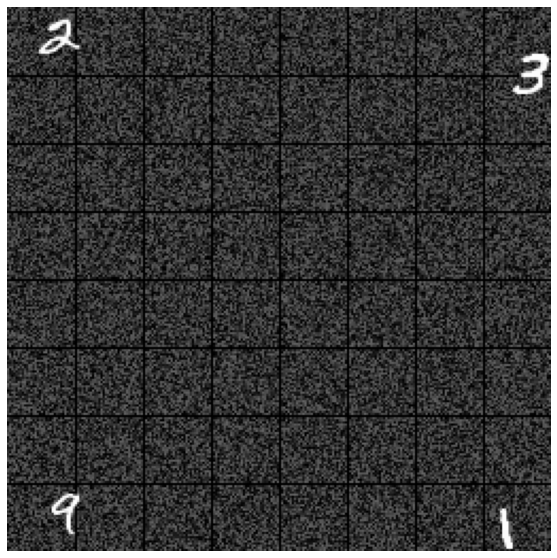

In [761]:
image = generate_noisy_image(size = (256, 256), intensity = 100)
draw_grid_on_image(image, grid_height = 8, grid_width = 8)

image = add_object_to_image(image = image,
                            region_of_interest = 1,
                            object = x_train[5],
                            label = y_train_bboxes[5],
                            grid_height = 8,
                            grid_width = 8,
                            scale_value = 5,
                            topleft_bottomright_coordinates=True)

image = add_object_to_image(image = image,
                            region_of_interest = 8,
                            object = x_train[7],
                            label = y_train_bboxes[7],
                            grid_height = 8,
                            grid_width = 8,
                            scale_value = 5,
                            topleft_bottomright_coordinates=True)

image = add_object_to_image(image = image,
                            region_of_interest = 64,
                            object = x_train[6],
                            label = y_train_bboxes[6],
                            grid_height = 8,
                            grid_width = 8,
                            scale_value = 5,
                            topleft_bottomright_coordinates=True)

image = add_object_to_image(image = image,
                            region_of_interest = 57,
                            object = x_train[4],
                            label = y_train_bboxes[4],
                            grid_height = 8,
                            grid_width = 8,
                            scale_value = 5,
                            topleft_bottomright_coordinates=True)

plot_image_from_grayscale(image)

In [771]:
def create_image(objects,
                 labels,
                 image_size = (128, 128),
                 noise_intensity = 180,
                 grid_height = 4,
                 grid_width = 4,
                 max_objects = 8,
                 max_scaling = 2.5,
                 add_gridlines = False,
                 topleft_bottomright_coordinates=True):
    
    image = generate_noisy_image(size = image_size,
                                 intensity = noise_intensity)
    
    data_size = len(objects)
    scaling_options = np.arange(1, max_scaling + 0.125, 0.125)

    regions_to_populate = choose_regions_to_populate(max_objects=max_objects,
                                                     grid_height = grid_width,
                                                     grid_width = grid_width)
    
    if add_gridlines:
        image = draw_grid_on_image(image, 
                                   grid_height = grid_height, 
                                   grid_width = grid_width)
    
    for region in regions_to_populate:
        index = np.random.randint(0, data_size)
        scaler = np.random.choice(scaling_options)
        image = add_object_to_image(image = image,
                                    region_of_interest = region,
                                    object = objects[index],
                                    label = labels[index],
                                    grid_height = grid_height,
                                    grid_width = grid_width,
                                    scale_value = scaler,
                                    topleft_bottomright_coordinates=topleft_bottomright_coordinates)
        print("region: {} , number: {}".format(region, int(labels[index, 0])))
    
    return image

region: 6 , number: 3


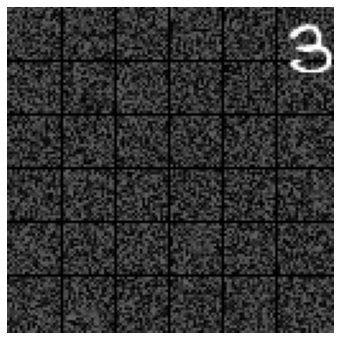

In [801]:
test = create_image(x_train,
                    y_train_bboxes,
                    image_size=(128, 128),
                    noise_intensity=100,
                    grid_height=6,
                    grid_width=6,
                    max_objects=8,
                    max_scaling=2.5,
                    add_gridlines=True,
                    topleft_bottomright_coordinates=True)

plot_image_from_grayscale(test)

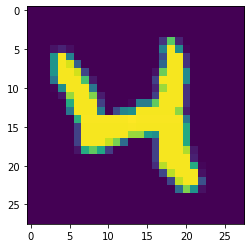

In [581]:
plt.imshow(x_train[20])